In [1]:
import numpy as np
import scipy.fftpack as fftpack
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
%matplotlib inline
font_prop = font_manager.FontProperties(size=16)

# Global Signals in Time Series Data

By Abigail Stevens

# Problem 1: Timmer and Koenig algorithm

The algorithm outlined in Timmer & Koenig 1995 lets you define the shape of your power spectrum (a power law with some slope, a Lorentzian, a sum of a couple Lorentzians and a power law, etc.) then generate the random phases and amplitudes of the Fourier transform to simulate light curves defined by the power spectral shape. This is a great simulation tool to have in your back pocket (or, "maybe useful someday" github repo).

#### Define some basic parameters for the power spectrum and resultant light curve

In [30]:
n_bins = 8192  ## number of total frequency bins in a FT segment; same as number of time bins in the light curve
dt = 1./16.  # time resolution of the output light curve
df = 1. / dt / n_bins

## 1a. Make an array of Fourier frequencies
Yes you can do this with scipy, but the order of frequencies in a T&K power spectrum is different than what you'd get by default from a standard FFT of a light curve.
You want the zero frequency to be in the middle (at index n_bins/2) of the frequency array. The positive frequencies should have two more indices than the negative frequencies, because of the zero frequency and nyquist frequency. You can either do this with `np.arange` or with special options in `fftpack.fftfreq`.

In [31]:
#freq = fftpack.fftfreq(n_bins, d=df)
freqs = np.arange(float(-n_bins/2)+1, float(n_bins/2)+1) * df
pos_freq = freqs[np.where(freqs >= 0)]
## Positive should have 2 more than negative, 
## because of the 0 freq and the nyquist freq
neg_freq = freqs[np.where(freqs < 0)]
nyquist = pos_freq[-1]
len_pos = len(pos_freq)

## 1b. Define a Lorentzian function and power law function for the shape of the power spectrum

In [9]:
def lorentzian(v, v_0, gamma):
    """ Gives a Lorentzian centered on v_0 with a FWHM of gamma """
    numerator = gamma / (np.pi * 2.0)
    denominator = (v - v_0) ** 2 + (1.0/2.0 * gamma) ** 2
    L = numerator / denominator
    return L

def powerlaw(v, beta):
    """Gives a powerlaw of (1/v)^-beta """
    pl = np.zeros(len(v))
    pl[1:] = v[1:] ** (-beta)
    pl[0] = np.inf
    return pl

## Now the T&K algorithm. I've transcribed the 'recipe' section of the T&K95 paper, which you will convert to lines of code. 

## 1c. Choose a power spectrum $S(\nu)$. 
We will use a sum of one Lorentzians (a QPO with a centroid frequency of 0.5 Hz and a FWHM of 0.01 Hz), and a Poisson-noise power law. The QPO should be 100 times larger amplitude than the power-law.

In [34]:
power_shape = 100 * lorentzian(pos_freq, 0.5, 0.01) + powerlaw(pos_freq, 0)

## 1d.  For each Fourier frequency $\nu_i$ draw two gaussian-distributed random numbers, multiply them by $$\sqrt{\frac{1}{2}S(\nu_i)}$$ and use the result as the real and imaginary part of the Fourier transform $F$ of the desired data.
In the case of an even number of data points, for reason of symmetry $F(\nu_{Nyquist})$ is always real. Thus only one gaussian distributed random number has to be drawn.

In [6]:
from numpy.random import randn

In [35]:
np.random.seed(3)
rand_r = np.random.standard_normal(len_pos)
rand_i = np.random.standard_normal(len_pos-1)
rand_i = np.append(rand_i, 0.0) # because the nyquist frequency should only have a real value

## Creating the real and imaginary values from the lists of random numbers and the frequencies
r_values = rand_r * np.sqrt(0.5 * power_shape)
i_values = rand_i * np.sqrt(0.5 * power_shape)
r_values[np.where(pos_freq == 0)] = 0
i_values[np.where(pos_freq == 0)] = 0

## 1e. To obtain a real valued time series, choose the Fourier components for the negative frequencies according to $F(-\nu_i)=F*(\nu_i)$ where the asterisk denotes complex conjugation. 

Append to make one fourier transform array. Check that your T&K fourier transform has length `n_bins`. Again, for this algorithm, the zero Fourier frequency is in the middle of the array, the negative Fourier frequencies are in the first half, and the positive Fourier frequencies are in the second half.

In [36]:
FT_pos = r_values + i_values*1j
FT_neg = np.conj(FT_pos[1:-1]) 
FT_neg = FT_neg[::-1]  ## Need to flip direction of the negative frequency FT values so that they match up correctly
FT = np.append(FT_pos, FT_neg)


## 1f. Obtain the time series by backward Fourier transformation of $F(\nu)$ from the frequency domain to the time domain.

Note: I usually use `.real` after an iFFT to get rid of any lingering 1e-10 imaginary factors.

In [37]:
lc = fftpack.ifft(FT).real

Congratulations! 
## 1g. Plot the power spectrum of your FT (only the positive frequencies) next to the light curve it makes. 
Remember: $$P(\nu_i)=|F(\nu_i)|^2$$

/Users/rmorgan/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


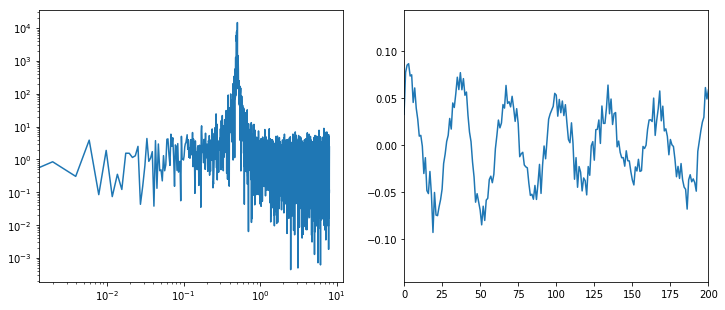

In [48]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 5))
ax1.loglog(pos_freq, np.abs(FT_pos)**2)

ax2.plot(np.linspace(0, len(lc), len(lc)), lc)
ax2.set_xlim(0, 200)
fig.show()

You'll want to change the x scale of your light curve plot to be like 20 seconds in length, and only use the positive Fourier frequencies when plotting the power spectrum.

Yay!

## 1h. Play around with your new-found simulation powers (haha, it's a pun!) 
Make more power spectra with different features -- try at least 5 or 6, and plot each of them next to the corresponding light curve. Try red noise, flicker noise, a few broad Lorentzians at lower frequency, multiple QPOs, a delta function, etc. 

Here are some other functions you can use to define shapes of power spectra. This exercise is to help build your intuition of what a time signal looks like in the Fourier domain and vice-versa.

In [47]:
def gaussian(v, mean, std_dev):
    """
    Gives a Gaussian with a mean of mean and a standard deviation of std_dev
    FWHM = 2 * np.sqrt(2 * np.log(2))*std_dev
    """
    exp_numerator = -(v - mean)**2
    exp_denominator = 2 * std_dev**2
    G = np.exp(exp_numerator / exp_denominator)
    return G

def powerlaw_expdecay(v, beta, alpha):
    """Gives a powerlaw of (1/v)^-beta with an exponential decay e^{-alpha*v} """
    pl_exp = np.where(v != 0, (1.0 / v) ** beta * np.exp(-alpha * v), np.inf) 
    return pl_exp

def broken_powerlaw(v, v_b, beta_1, beta_2):
    """Gives two powerlaws, (1/v)^-beta_1 and (1/v)^-beta_2 
       that cross over at break frequency v_b."""
    c = v_b ** (-beta_1 + beta_2)  ## scale factor so that they're equal at the break frequency
    pl_1 = v[np.where(v <= v_b)] ** (-beta_1)
    pl_2 = c * v[np.where(v > v_b)] ** (-beta_2)
    pl = np.append(pl_1, pl_2)
    return pl

# 2. More realistic simulation with T&K
Now you're able to simulate the power spectrum of a single segment of a light curve. However, as you learned this morning, we usually use multiple (~50+) segments of a light curve, take the power spectrum of each segment, and average them together.

## 2a. Turn the code from 1d to 1e into a function `make_TK_seg`
Make it so that you can give a different random seed to each segment.

## 2b. Make the Fourier transform for a given power shape (as in Problem 1)
Use a Lorentzian QPO + Poisson noise power shape at a centroid frequency of 0.5 Hz and a full width at half maximum (FWHM) of 0.01 Hz. Make the QPO 100 time stronger than the Poisson noise power-law.

## 2c. Put `make_TK_seg` in a loop to do for 50 segments. 
Make an array of integers that can be your random gaussian seed for the TK algorithm (otherwise, you run the risk of creating the exact same Fourier transform every time, and that will be boring).

Keep a running average of the power spectrum of each segment (like we did this morning in problem 2).

## 2d. Compute the error on the average power
The error on the power at index $i$ is
$$ \delta P_i = \frac{P_i}{\sqrt{M}} $$
where `M` is the number of segments averaged together.

## 2e. Use the re-binning algorithm described in the morning's workbook to re-bin the power spectrum by a factor of 1.05.

## Plot the average power spectrum
Remember to use log scale for the y-axis and probably the x-axis too!

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(8,5))
ax.plot(rb_freq, rb_pow, linewidth=2.0)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'Frequency (Hz)', fontproperties=font_prop)
ax.tick_params(axis='x', labelsize=16, bottom=True, top=True, 
               labelbottom=True, labeltop=False)
ax.tick_params(axis='y', labelsize=16, left=True, right=True, 
               labelleft=True, labelright=False)
plt.show()

## 2f. Re-do 2b through the plot above but slightly changing the power spectrum shape in each segment. 
Maybe you change the centroid frequency of the QPO, or the normalizing factors between the two components, or the slope of the power-law.

# Bonus problems:

## 1. Use a different definition of the Lorentzian (below) to make a power spectrum. 
Follow the same procedure. Start off with just one segment. Use the rms as the normalizing factor.

## 2. Using what you learned about data visualization earlier this week, turn the plots in this notebook (and the QPO one, if you're ambitious) into clear and easy-to-digest, publication-ready plots.

In [ ]:
def lorentz_q(v, v_peak, q, rms):  
    """ 
    Form of the Lorentzian function defined in terms of 
    peak frequency v_peak and quality factor q
    q = v_peak / fwhm
    with the integrated rms of the QPO as the normalizing factor.
    e.g. see Pottschmidt et al. 2003, A&A, 407, 1039 for more info
    """
    f_res = v_peak / np.sqrt(1.0+(1.0/(4.0*q**2)))
    r = rms / np.sqrt(0.5-np.arctan(-2.0*q)/np.pi)
    lorentz = ((1/np.pi)*2*r**2*q*f_res) / (f_res**2+(4*q**2*(v-f_res)**2))
    return lorentz